# Create Tensorflow Dataset
**Author:** Scott Campit

# Summary
This notebook specifically reformats the Supervise.ly project and creates a tensorflow object.

In [12]:
# Base libraries
import numpy as np
import json
import itertools
import random
import os
import random
import pandas as pd

# Deep learning libraries
import keras
from keras import layers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

# Computer vision libraries
import cv2
import PIL.Image as Image
from skimage import io
import supervisely_lib as sly

# Data visualization libraries
from pylab import rcParams
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 1. Read in data
We labeled the data using Supervisely. Let's load up the project.

In [17]:
proj_path = "D:/Data/InterOp/Sling Health"
project = sly.Project(proj_path, sly.OpenMode.READ)

If we are going to use ImageNet, the size of the image needs to be 224 x 224.

In [18]:
IMAGE_SHAPE = (224, 224)

Let's load up a single image and its respective annotation.

In [19]:
item_paths = project.datasets.get("Thyroidectomy").get_item_paths("thyroidectomy_0_9.jpg")
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)

Now let's perform some resizing and processing.

In [20]:
# Read the underlying raw image for display.
img = sly.image.read(item_paths.img_path)
img = cv2.resize(img, dsize=IMAGE_SHAPE)
img = np.array(img) / 255.0

# Render the labeled objects.
ann_render = np.zeros(ann.img_size + (3,), dtype=np.uint8)
ann.draw(ann_render)
ann_render = cv2.resize(ann_render, dsize=IMAGE_SHAPE)

# Separately, render the labeled objects contours.
ann_contours = np.zeros(ann.img_size + (3,), dtype=np.uint8)
ann.draw_contour(ann_contours, thickness=7)
ann_contours = cv2.resize(ann_contours, dsize=IMAGE_SHAPE)

Let's now plot the image.

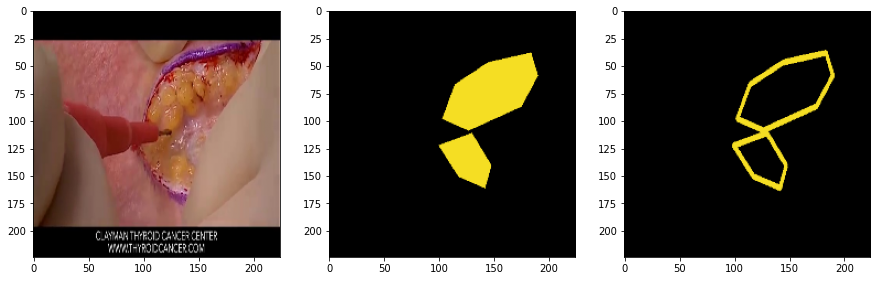

In [21]:
# Plot the image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(ann_render)
plt.subplot(1, 3, 3)
plt.imshow(ann_contours)

# 2. Write up data preprocessing functions
## Structure images for splitting data into train and test.
First, let's get all the paths in the directory.

In [7]:
def ReadPaths(paths):
    """
    """
    all_paths = []
    for path in paths:
        temp_paths = ReadDirFiles(path)
        all_paths.extend(temp_paths)
    return all_paths

Then for each directory, add on the image and the mask to the base directory name.

In [5]:
def ReadDirFiles(dirname):
    """
    """
    paths = []
    for file in os.listdir(os.path.join(dirname, "img")):
        basename = os.path.basename(file).split(".")[0]
        
        img_name = os.path.join(dirname, "img", file)
        ann_name = os.path.join(dirname, "ann", basename + ".json")
        paths.append((img_name, ann_name))
    return paths

In [8]:
datapath = ['D:\\Data\\InterOp\\Sling Health\\Thyroidectomy\\']
all_paths = ReadPaths(datapath)
#print(all_paths)

Now let's separate out files that will be used for training and testing.

In [9]:
def train_test_split(paths, train_size=0.8, train_tag="train", test_tag="test"):
    """
    """
    train_paths = []
    test_paths  = []

    n_img   = len(all_paths)
    train_size = 0.8
    n_train = [train_tag] * round(n_img * train_size)
    n_test  = [test_tag] * (n_img-len(n_train))
    select_tag = n_train + n_test
    random.shuffle(select_tag)

    for i, path in enumerate(paths):
        img_path, ann_path = path
        tags = select_tag[i]
        if train_tag in tags:
            train_paths.append(path)
        if test_tag in tags:
            test_paths.append(path)
    return train_paths, test_paths

In [13]:
train_paths, test_paths = train_test_split(all_paths)
print(len(train_paths))
print(len(test_paths))

364
91


## Create the dataloader
We need to specify some information for our images. 

First, let's grab the meta data. Specifically we'll grab the unique classes in this dataset.

In [32]:
meta = "D:/Data/InterOp/Sling Health/meta.json"
f = open(meta)
data = json.load(f)
f.close()

# Grab unique classes in the meta data
ids = []
for i in range(len(data['classes'])):
    ids.append(data['classes'][i]['title'])

## Create new directory with the final split
Now we need to create a dataset object that has the following structure:
```
data
  |
  |--train
       |--image
       |--mask      
  |--test
       |--image
       |--mask

```

In [33]:
proj_path = "D:/Data/InterOp/Sling Health"
project = sly.Project(proj_path, sly.OpenMode.READ)
IMAGE_SHAPE = (224, 224)

img_list = []
mask_list = []
for i in train_paths:
    jpg = i[0].split(sep='\\')[-1]
    item_paths = project.datasets.get("Thyroidectomy").get_item_paths(jpg)
    ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)

    # Get image, resize, and normalize
    img = sly.image.read(item_paths.img_path)
    img = cv2.resize(img, dsize=IMAGE_SHAPE)
    img = np.array(img) / 255.0
    img_list.append(img)

    # Render the labeled objects and resize
    ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
    ann_render = np.zeros(ann.img_size + (3,), dtype=np.uint8)
    ann.draw(ann_render)
    ann_render = cv2.resize(ann_render, dsize=IMAGE_SHAPE)
    mask_list.append(ann_render)

In [53]:
print(len(np.asarray(img_list)))
print(len(np.asarray(mask_list)))
image_tf = tf.convert_to_tensor(np.asarray(img_list))
mask_tf = tf.convert_to_tensor(np.asarray(mask_list))

print(len(image_tf))
print(len(mask_tf))

train_dataset = tf.data.Dataset.from_tensor_slices((image_tf, mask_tf))

364
364
364
364


In [59]:
print(train_dataset)
print(train_dataset[0])

<TensorSliceDataset shapes: ((224, 224, 3), (224, 224, 3)), types: (tf.float64, tf.uint8)>


TypeError: 'TensorSliceDataset' object is not subscriptable

In [57]:
@tf.function
def load_training_image(datapoint, image_size=(128, 128)):
    """
    """
    input_image = datapoint[0]
    input_mask = datapoint[1]
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask
train_dataset = train_dataset.map(load_training_image)

ValueError: in user code:

    <ipython-input-55-5d6b53a96bd3>:8 load_training_image  *
        input_image = tf.image.flip_left_right(input_image)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:562 flip_left_right
        return _flip(image, 1, 'flip_left_right')
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:621 _flip
        image = _AssertAtLeast3DImage(image)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:200 _AssertAtLeast3DImage
        _CheckAtLeast3DImage(image, require_static=False), image)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:224 _CheckAtLeast3DImage
        raise ValueError("'image' (shape %s) must be at least three-dimensional." %

    ValueError: 'image' (shape (224, 3)) must be at least three-dimensional.
